In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize
from tqdm import tqdm
import cv2
import random

/home/manu_kohli/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
# KERAS IMPORTS
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import concatenate, add
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import Conv2DTranspose
# from tensorflow.keras.layers import MaxPool2D, AvgPool2D
# from tensorflow.keras.layers import UpSampling2D
# # from tensorflow.keras.layers.advanced_activations import LeakyReLU
# from tensorflow.keras.layers import LeakyReLU
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Lambda
# from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Reshape
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import Add, Multiply
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.losses import mse, binary_crossentropy

# import tensorflow.keras.backend as K
# from tensorflow.keras.utils import multi_gpu_model

import tensorflow as tf
import keras
from keras.layers import concatenate, add
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.utils import plot_model
from keras.layers import Add, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import mse, binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.utils import multi_gpu_model
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [7]:
# Set some parameters
im_width = 128
im_height = 128
n_channels = 3
border = 5
n_filters=16
dropout=0.05
batchnorm=True
b_size = 16
path_train = './Dataset/Compaq_orignal/Compaq_orignal/Compaq_orignal/train/'
path_valid = './Dataset/Compaq_orignal/Compaq_orignal/Compaq_orignal/test/'
path_test = './Dataset/NIR_Dataset_New/'
# path_test_NIR_pred = './predict_image/vae_unet_b4/'
# path_train_comp_pred = './predict_image/vae_unet_compaq/train/'
# path_test_comp_pred = './predict_image/vae_unet_compaq/test/'

In [8]:
import cv2
img_size = 128
def get_data(train_data_path):
    img_size = 128
#     train_ids = next(os.walk(train_data_path))[1]
    train_ids = next(os.walk(train_data_path + "image/1"))[2]
    
    x_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
    y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)

    for i, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
        path = train_data_path+"image/1"+"/{}".format(id_)
        img = cv2.imread(path,1)
        img = cv2.resize(img, (img_size, img_size))
        x_train[i]=img

        height, width, _ = img.shape
        label = np.zeros((height, width, 1))
        path2 = train_data_path+"label/1/"
        mask_ = cv2.imread(path2+id_, 0)
        mask_ = cv2.resize(mask_, (img_size, img_size))
        mask_ = np.expand_dims(mask_, axis=-1)
        label = np.maximum(label, mask_)
        y_train[i]=label
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train).astype(np.uint8)
    return x_train , y_train
X_train, y_train = get_data(path_train)
X_valid , y_valid = get_data(path_valid)
X_test_NIR , y_test_NIR = get_data(path_test)
# X_train_comp_pred , y_train_comp_pred = get_data(path_train_comp_pred)
# X_valid_comp_pred , y_valid_comp_pred = get_data(path_test_comp_pred)
# X_test_NIR_pred , y_test_NIR_pred = get_data(path_test_NIR_pred)

In [6]:
print(np.shape(X_test_NIR))
X_test_NIR_test , X_test_NIR_comp , y_test_NIR , y_test_NIR_comp = train_test_split(X_test_NIR , y_test_NIR , test_size = 0.20 , random_state = 42)
print(np.shape(X_test_NIR_test) , np.shape(X_test_NIR_comp))

(1240, 128, 128, 3)
(992, 128, 128, 3) (248, 128, 128, 3)


In [7]:
X_final = np.zeros((3516, img_size, img_size, 3), dtype=np.uint8)
y_final = np.zeros((3516, img_size, img_size, 1), dtype=np.bool)
for i,image in enumerate(X_train):
    X_final[i] = image
    y_final[i] = y_train[i]
for i, image in enumerate(X_test_NIR_comp):
    X_final[i+3268]=image
    y_final[i+3268]=y_test_NIR_comp[i]
y_final = np.asarray(y_final).astype(np.uint8)
X_final = np.asarray(X_final)
print(np.shape(X_final) , np.shape(y_final))

(3516, 128, 128, 3) (3516, 128, 128, 1)


In [9]:
# Check if training data looks all right
ix = random.randint(0, len(X_final))
# ix = 3515
has_mask = y_final[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# image = X_train[ix, ... , 0]
image = X_final[ix,:,:,:].reshape(128,128,3)
# image = (image + 1 ) / 2
# image = image * 255
ax[0].imshow(image.astype('uint8'))
if has_mask:
    ax[0].contour(y_final[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_final[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

NameError: name 'X_final' is not defined

In [10]:
# # import efficientnet 
# K.clear_session()
from efficientnet import EfficientNetB4

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model


In [11]:
# K.clear_session()
img_size = 128
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.20)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "u-xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 48)   192         conv2d_1[0][0]                   
________________________________

In [11]:
import tensorflow as tf

# def mean_iou(y_true, y_pred):
#     y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
#     inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
#     union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
#     return K.mean((inter + K.epsilon()) / (union + K.epsilon()))

In [12]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [13]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [14]:
class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(validation_data,
                                          validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)
            show_result = {}
            for i, result in enumerate(results):
                show_result["NIR_" + self.model.metrics_names[i]] = results[i]
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics_names[i-1]
                self.history.setdefault(valuename, []).append(result)
            print("           ")
            print("NIR Results")
            print(show_result)
            print("          ")

In [15]:
# X_test, y_test = get_data(path_test)

In [16]:
# NIR_history = AdditionalValidationSets([(X_test_NIR_test, y_test_NIR, 'NIR')])

In [15]:
# model.compile(loss=bce_logdice_loss, optimizer=Adam(1e-4 , decay = 1e-6), metrics=[iou_metric,dice_coef])
model.compile(loss=bce_logdice_loss, optimizer=keras.optimizers.RMSprop(lr=0.001 , decay=1e-3), metrics=[mean_iou,dice_coef,precision, recall, accuracy])

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1,monitor='val_loss'),
#     NIR_history,
    ModelCheckpoint('./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_with_20p_NIR.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
# history = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,
#                     validation_data=(X_valid, y_valid))

history = model.fit(X_final, y_final, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(X_test_NIR_test, y_test_NIR))



Instructions for updating:
Use tf.cast instead.
Train on 3516 samples, validate on 992 samples
Epoch 1/100
3516/3516 [==============================] - 164s 47ms/step - loss: 0.8045 - mean_iou: 0.4293 - dice_coef: 0.6820 - precision: 0.6295 - recall: 0.7712 - accuracy: 0.8761 - val_loss: 1.6141 - val_mean_iou: 0.1247 - val_dice_coef: 0.2645 - val_precision: 0.6129 - val_recall: 0.1735 - val_accuracy: 0.9730

Epoch 00001: val_loss improved from inf to 1.61410, saving model to ./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_with_20p_NIR.h5
Epoch 2/100
3516/3516 [==============================] - 143s 41ms/step - loss: 0.5518 - mean_iou: 0.5157 - dice_coef: 0.7665 - precision: 0.7527 - recall: 0.7970 - accuracy: 0.9187 - val_loss: 1.3151 - val_mean_iou: 0.1856 - val_dice_coef: 0.3423 - val_precision: 0.6216 - val_recall: 0.2388 - val_accuracy: 0.9739

Epoch 00002: val_loss improved from 1.61410 to 1.31508, saving model to ./models/u-efficientnet/1/u-efficientnet_bce_m

Epoch 19/100
3516/3516 [==============================] - 142s 40ms/step - loss: 0.1727 - mean_iou: 0.7651 - dice_coef: 0.9228 - precision: 0.9193 - recall: 0.9269 - accuracy: 0.9741 - val_loss: 0.7409 - val_mean_iou: 0.3359 - val_dice_coef: 0.5404 - val_precision: 0.7416 - val_recall: 0.4282 - val_accuracy: 0.9794

Epoch 00019: val_loss did not improve from 0.73862
Epoch 20/100
3516/3516 [==============================] - 142s 40ms/step - loss: 0.1677 - mean_iou: 0.7706 - dice_coef: 0.9252 - precision: 0.9211 - recall: 0.9298 - accuracy: 0.9748 - val_loss: 0.7104 - val_mean_iou: 0.3564 - val_dice_coef: 0.5578 - val_precision: 0.6809 - val_recall: 0.4756 - val_accuracy: 0.9786

Epoch 00020: val_loss improved from 0.73862 to 0.71045, saving model to ./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_with_20p_NIR.h5
Epoch 21/100
3516/3516 [==============================] - 142s 40ms/step - loss: 0.1652 - mean_iou: 0.7752 - dice_coef: 0.9261 - precision: 0.9220 - recall:


Epoch 00058: val_loss did not improve from 0.67180
Epoch 59/100
3516/3516 [==============================] - 145s 41ms/step - loss: 0.1413 - mean_iou: 0.8000 - dice_coef: 0.9366 - precision: 0.9324 - recall: 0.9410 - accuracy: 0.9785 - val_loss: 0.6723 - val_mean_iou: 0.3763 - val_dice_coef: 0.5768 - val_precision: 0.7064 - val_recall: 0.4911 - val_accuracy: 0.9796

Epoch 00059: val_loss did not improve from 0.67180
Epoch 60/100
3516/3516 [==============================] - 145s 41ms/step - loss: 0.1416 - mean_iou: 0.8007 - dice_coef: 0.9361 - precision: 0.9314 - recall: 0.9410 - accuracy: 0.9786 - val_loss: 0.6715 - val_mean_iou: 0.3767 - val_dice_coef: 0.5773 - val_precision: 0.7059 - val_recall: 0.4920 - val_accuracy: 0.9796

Epoch 00060: val_loss improved from 0.67180 to 0.67152, saving model to ./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_with_20p_NIR.h5
Epoch 61/100
3516/3516 [==============================] - 145s 41ms/step - loss: 0.1427 - mean_iou: 0.80

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['iou_metric'][1:])
plt.plot(history.history['val_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r")
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation','best_model'], loc='upper left')
plt.title('model loss')
# gc.collect()

In [ ]:
# keras.backend.clear_session()

In [16]:
#load model
model.load_weights('./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_final.h5')

In [17]:
# model.load_weights('./models/u-efficientnet/1/u-efficientnet_20p_NIR_final.h5')

In [20]:
#evaluate val
model.evaluate(X_test_NIR_pred, y_test_NIR_pred, verbose=1)

1240/1240 [==============================] - 12s 10ms/step


[1.3571292384978264,
 0.18997101485729218,
 0.32601937651634216,
 0.544590950012207,
 0.23624157905578613,
 0.9520872831344604]

In [19]:
#predict
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1400/1400 [==============================] - 11s 8ms/step


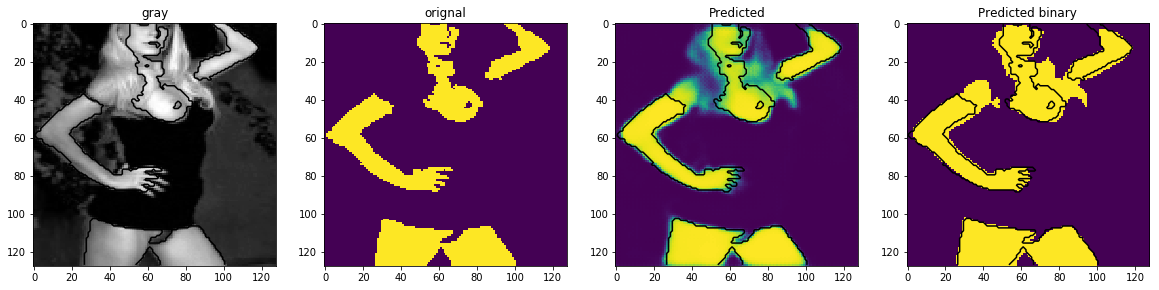

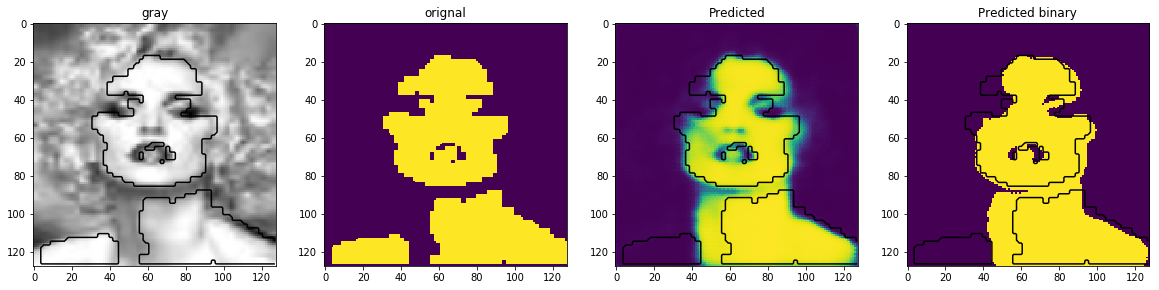

In [20]:
# visualize
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('gray')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('orignal')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [21]:
X_test, y_test = get_data(path_test)

In [22]:
#evaluate 
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

754/754 [==============================] - 6s 8ms/step
[1.064722674278745, 0.3181326985359192, 0.5231824517250061, 0.815757691860199, 0.38626372814178467, 0.8868504166603088]


In [17]:
#evaluate 
score_train = model.evaluate(X_train, y_train, verbose=1)
score_valid = model.evaluate(X_valid, y_valid, verbose=1)
score_test = model.evaluate(X_test_NIR, y_test_NIR)
print(score_train)
print(score_valid)
print(score_test)

754/754 [==============================] - 7s 9ms/step
[0.36019609855759244, 0.6304165720939636, 0.8498004078865051, 0.8199234008789062, 0.8827025294303894, 0.9435062408447266]
[0.5070900726318359, 0.5495524406433105, 0.7855911254882812, 0.7533115148544312, 0.8225597143173218, 0.918975830078125]
[1.0647226508795742, 0.3181324005126953, 0.5231818556785583, 0.8157574534416199, 0.3862631618976593, 0.8868503570556641]


In [23]:
preds_test = model.predict(X_test, verbose=1)
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

754/754 [==============================] - 6s 8ms/step


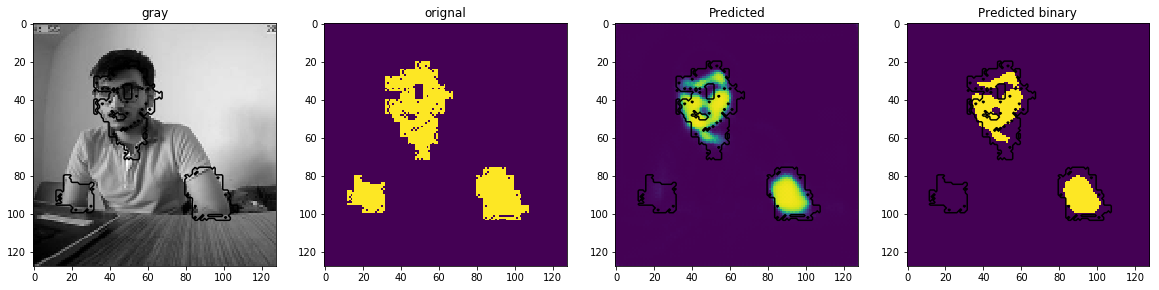

In [24]:
#visualize
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=16)

In [29]:
def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
     y_pred = y_pred.flatten()
     y_true = y_true.flatten()
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU)
    
compute_iou(preds_test_t , y_test)

0.7188015886545233

In [28]:
compute_iou(preds_val_t , y_valid)

NameError: name 'compute_iou' is not defined

In [24]:
# evaluation on predicted images
score_train_pred = model.evaluate(X_train_comp_pred, y_train_comp_pred, verbose=1)
score_valid_pred = model.evaluate(X_valid_comp_pred, y_valid_comp_pred, verbose=1)
score_test_pred = model.evaluate(X_test_NIR_pred, y_test_NIR_pred, verbose=1)
print(score_train_pred)
print(score_valid_pred)
print(score_test_pred)

1240/1240 [==============================] - 10s 8ms/step
[0.7938745636105391, 0.4218956530094147, 0.6858971118927002, 0.8593326807022095, 0.5719977021217346, 0.8858338594436646]
[0.9067314743995667, 0.3857980966567993, 0.6444942951202393, 0.8136804699897766, 0.5353754758834839, 0.871312141418457]
[2.0254445260570897, 0.08423888683319092, 0.1656871736049652, 0.1863601952791214, 0.1529950648546219, 0.924161970615387]
